# Visualisations for presentation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./shapley_compute/')

In [2]:
from shapley_compute.simulations.regressions import normal_linear_model, correlated_features_regression
from shapley_compute.ensembled_mp import mp_shapley, loco_error
from shapley_compute.minipatches import minipatch_regression, get_minipatch
from shapley_compute.locomp import LOCOMPReg, LOCOMP_random

In [3]:
from sklearn.linear_model import Lasso, RidgeCV, LinearRegression

# Feature importance scores

## Linear normal model

In [23]:
M = 20 # features
N = 1000 # observations
rho = 0.8
s = 0.5
SNR = 2
y, X, beta = normal_linear_model(N, M, s=s, SNR=SNR)  # N, M, SNR = 10, sigma2=0.4, s=0.2

<BarContainer object of 20 artists>

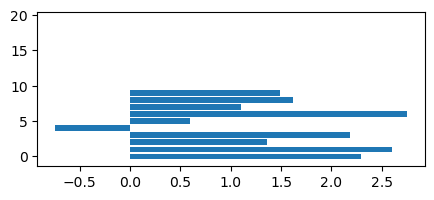

In [15]:
plt.figure(figsize=(5,2))
plt.barh([i for i in range(M)], beta)

In [42]:
import shap

# Define your value function
def value_function(y_true, y_pred):
    return np.abs(y_true - y_pred)

model = Lasso()
model.fit(X, y)
predictions = model.predict(X)
explainer = shap.Explainer(model, X)  # initialize explainer
shap_values = explainer.shap_values(X)
values = value_function(y, predictions) # calculate value function for each instance
# Apply value function to SHAP values
shap_values_v = shap_values * values[:, np.newaxis]


<BarContainer object of 20 artists>

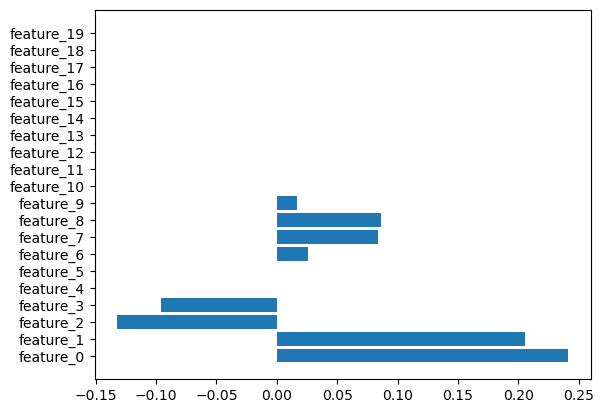

In [45]:
# Interpret the results
#plt.barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))
plt.barh(['feature_{}'.format(i) for i in range(M)],np.mean(shap_values_v,axis=0))

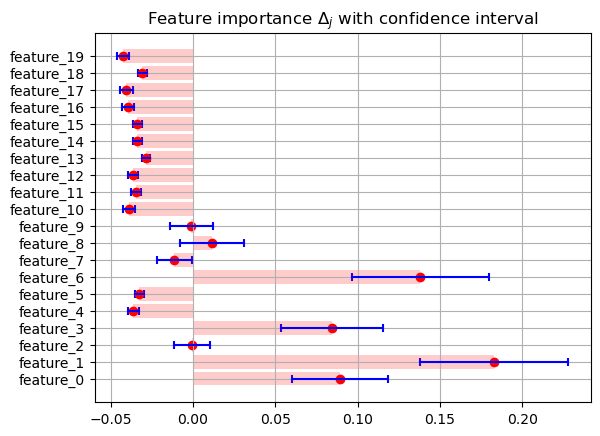

<Figure size 640x480 with 0 Axes>

In [103]:
def plot_CI(a, b, c):
    for i in range(len(a)):
        plt.plot([a[i], c[i]], [i, i], color='b')  # Plot a line segment between (a[i], i) and (c[i], i)
        plt.scatter([a[i], c[i]], [i, i], marker='|', color='b')  # Plot markers at (a[i], i), (b[i], i), and (c[i], i)
        plt.scatter(b[i], [i], marker='o', color='red')
    plt.yticks(np.arange(len(a)), ['feature_{}'.format(i) for i in range(len(a))])  # Set y-axis ticks

    # plt.ylabel('Feature importance score')
    plt.title('Feature importance $\Delta_j$ with confidence interval')
    plt.barh(['feature_{}'.format(i) for i in range(M)], b, color='red', alpha=0.2)
    plt.grid(True)
    plt.show()
left = res['loco_ci'][:,2]
right = res['loco_ci'][:, 3]
delta = res['info'].groupby('j').mean().zz
plot_CI(left, delta, right)
plt.savefig('./figures/NLM_Lasso_feature_plot_CI.svg')

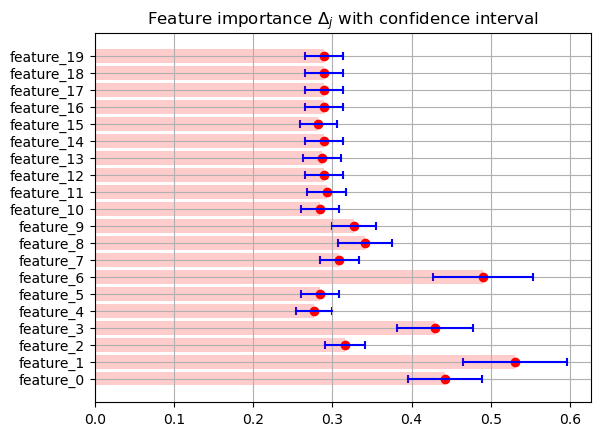

<Figure size 640x480 with 0 Axes>

In [105]:
left = res_random['loco_ci'][:,2]
right = res_random['loco_ci'][:, 3]
delta = res_random['info'].groupby('j').mean().zz
plot_CI(left, delta, right)
plt.savefig('./figures/NLM_Lasso_feature_plot_CI_random_patches.svg')

100%|██████████| 1000/1000 [00:08<00:00, 119.06it/s]


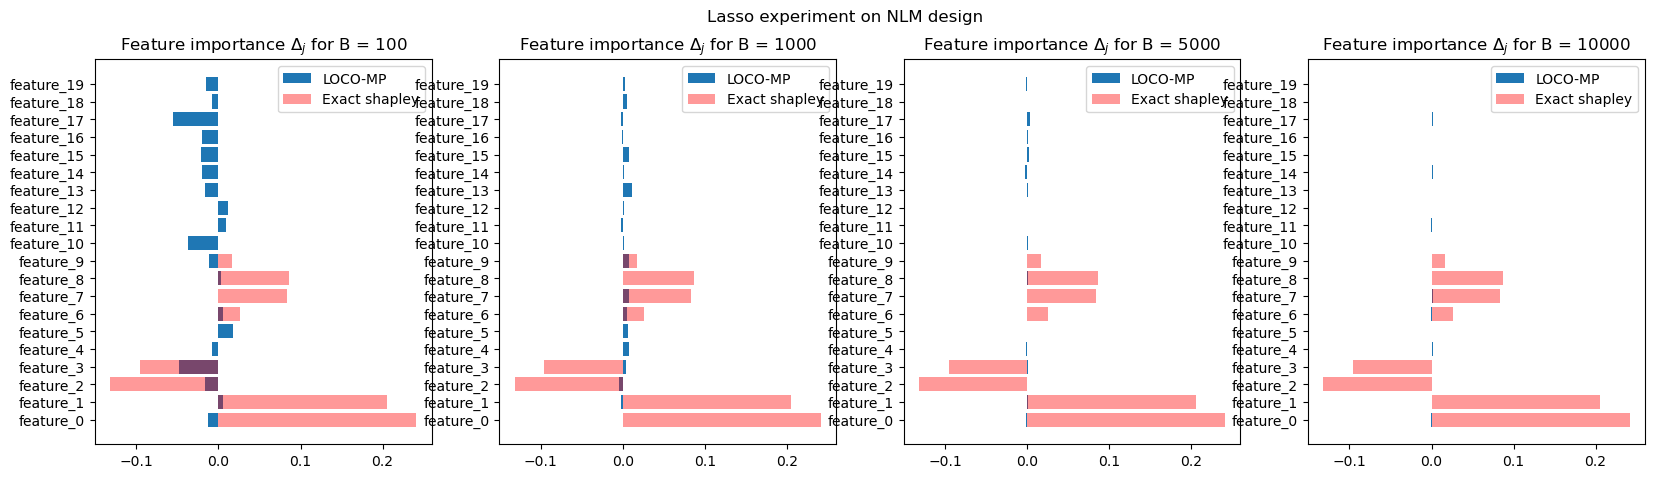

In [46]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    Delta = loco_error(X,y, model, x_ratio,list_B[b])
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.suptitle('Lasso experiment on NLM design')
plt.savefig('./figures/NLM_mine_locomp_Lasso_SNR{}.svg'.format(SNR))

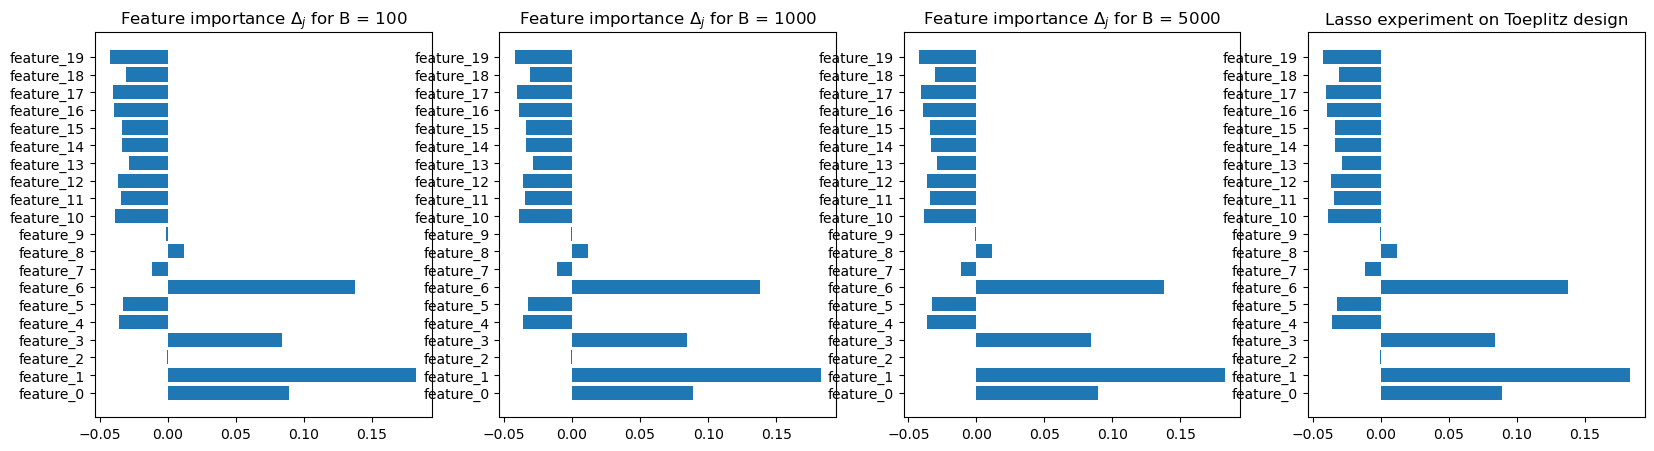

In [104]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res_random = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_locomp_Lasso_SNR{}.svg'.format(SNR))

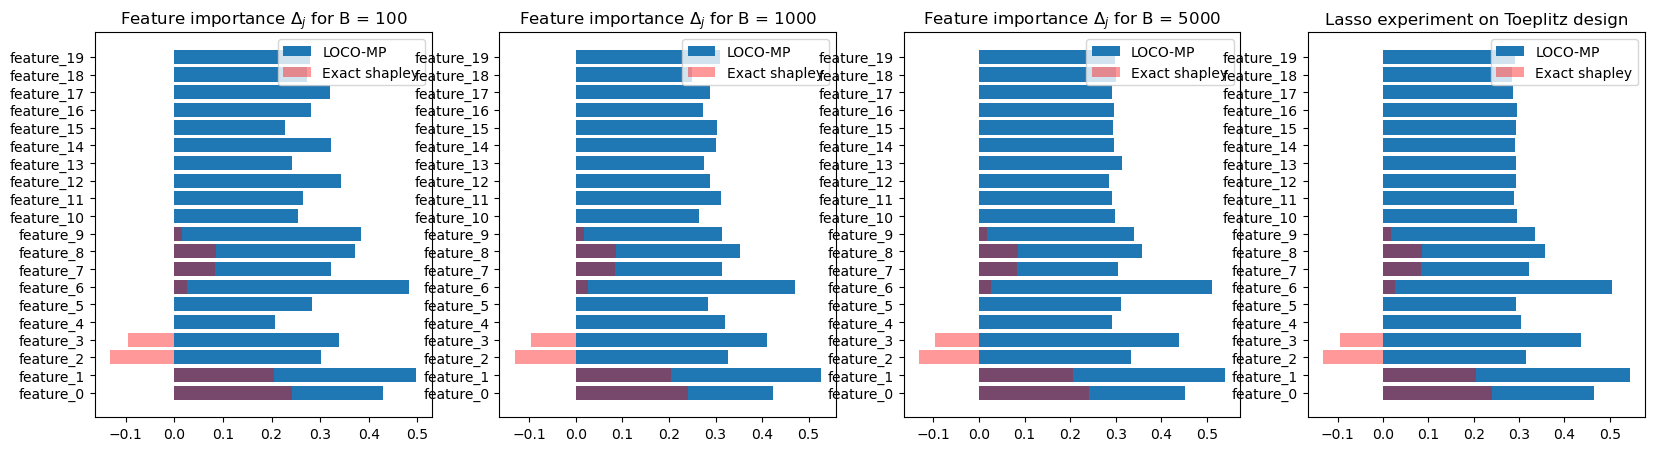

In [55]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.5
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_locomp_Lasso_SNR{}.svg'.format(SNR))

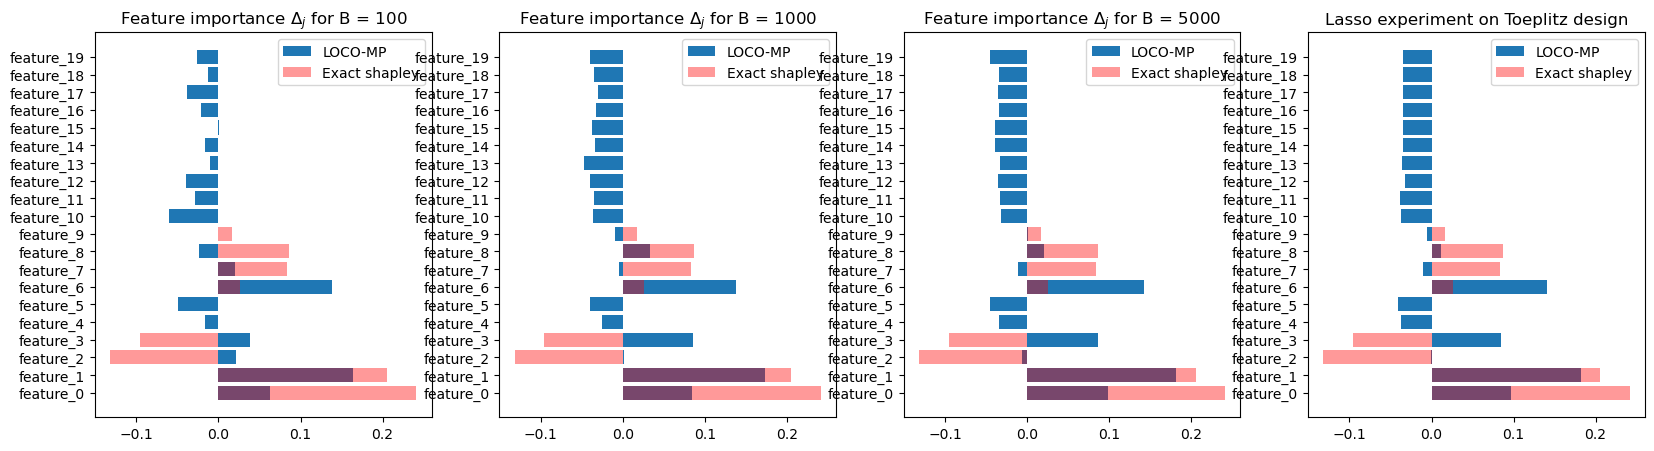

In [47]:
list_B = [100, 1000, 5000, 10000]
n_ratio = 0.2
m_ratio = 0.3
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMPReg(X,y,n_ratio, m_ratio,list_B[b], model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/NLM_og_locomp_Lasso_SNR{}.svg'.format(SNR))

## Toeplitz design

In [4]:
M = 20 # features
N = 1000 # observations
rho = 0.8
s = 0.5
SNR = 2
y, X, beta = correlated_features_regression(N, M, s=s, SNR=SNR, type='toeplitz') #toeplitz or equi-corr

<BarContainer object of 20 artists>

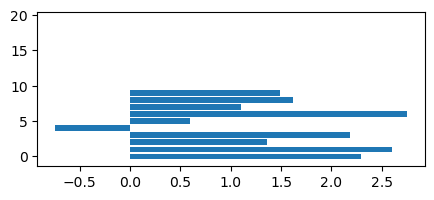

In [5]:
plt.figure(figsize=(5,2))
plt.barh([i for i in range(M)], beta)

100%|██████████| 1000/1000 [00:13<00:00, 75.61it/s]


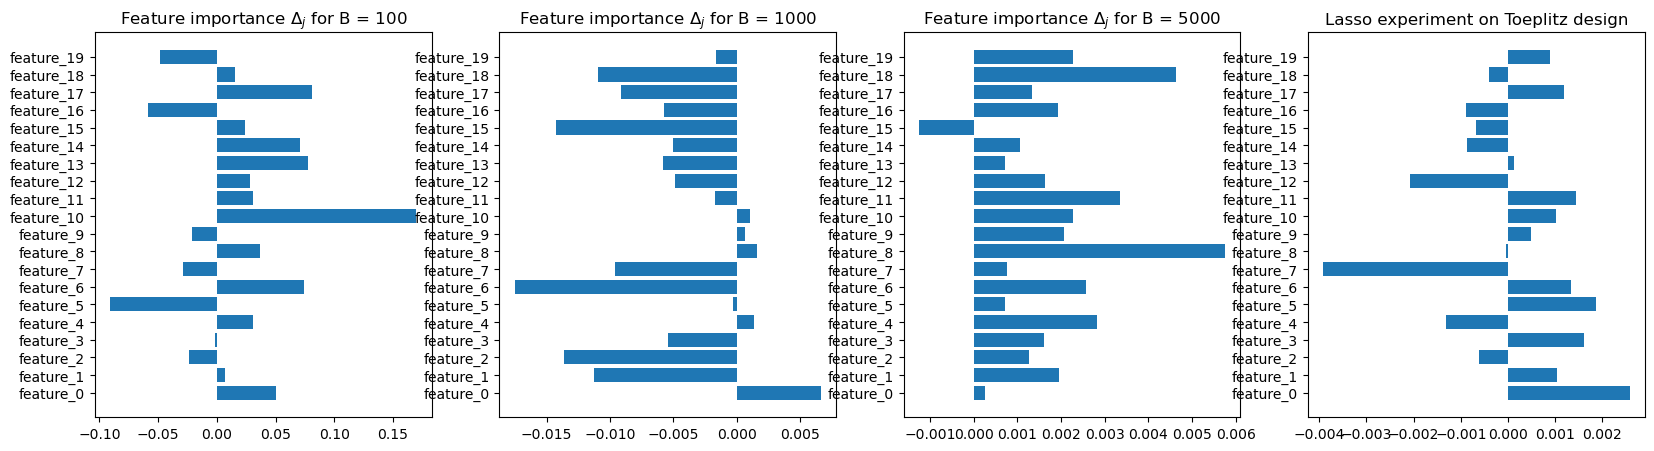

In [8]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    Delta = loco_error(X,y, model, x_ratio,list_B[b])
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.suptitle('Lasso experiment on Toeplitz design')
plt.savefig('./figures/mine_locomp_Lasso_SNR{}.svg'.format(SNR))

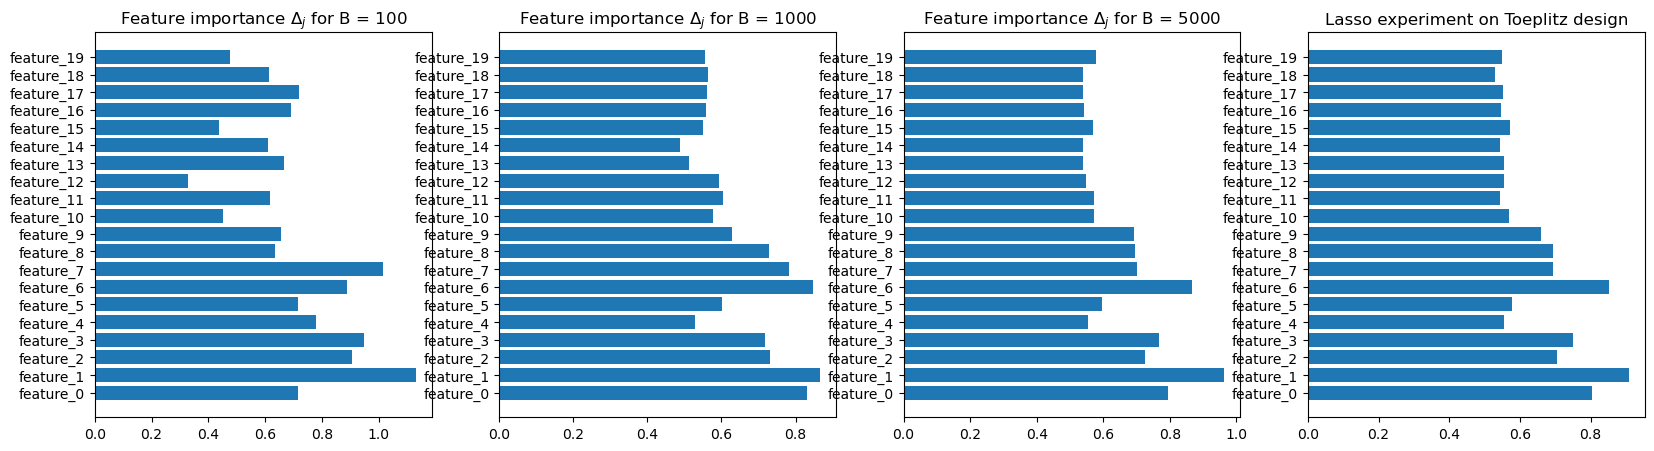

In [10]:
list_B = [100, 1000, 5000, 10000]
x_ratio = 0.2
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMP_random(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.title('Lasso experiment on Toeplitz design')
plt.savefig('./figures/locomp_Lasso_SNR{}.svg'.format(SNR))

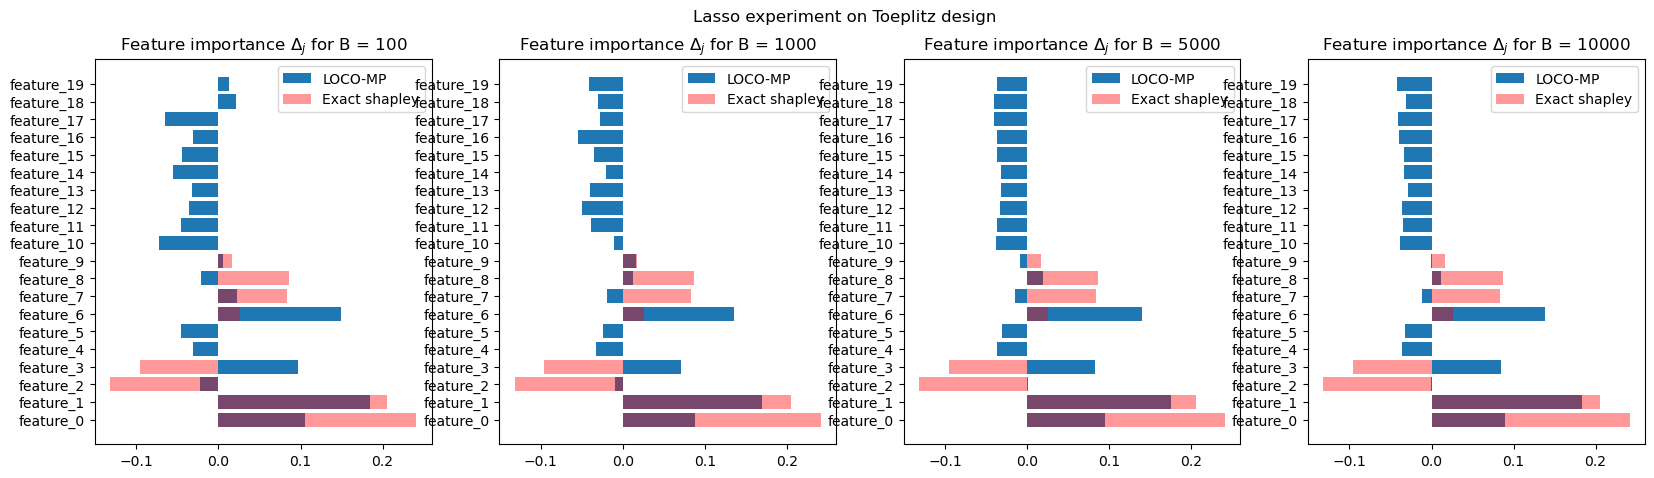

In [56]:
list_B = [100, 1000, 5000, 10000]
n_ratio = 0.2
m_ratio = 0.3
model = Lasso()
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMPReg(X,y,n_ratio, m_ratio,list_B[b], model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_values_v,axis=0), color='red', alpha=0.4)
    ax[b].legend(['LOCO-MP','Exact shapley'])
plt.suptitle('Lasso experiment on Toeplitz design')
plt.savefig('./figures/og_locomp_Lasso_SNR{}.svg'.format(SNR))